<a href="https://colab.research.google.com/github/hhandc/drug_repo/blob/main/drug_repurposing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
!pip install PyTDC rdkit biopython scikit-learn pandas numpy

# Predicting Drug to Target Interaction Score

In [14]:
from tdc.multi_pred import DTI
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from google.colab import files

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

print("Loading Drug-Target Interaction (DTI) dataset...")
data = DTI(name='BindingDB_Kd')

df = data.get_data()
print(f"Dataset loaded with {len(df)} entries")

amyloid_beta_smiles = "CC[C@H](C)[C@@H](C(=O)N[C@@H]([C@@H](C)CC)C(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](C(C)C)C(=O)NCC(=O)NCC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)O)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CC3=CNC=N3)NC(=O)[C@H](CC4=CNC=N4)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC5=CC=C(C=C5)O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC6=CNC=N6)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC7=CC=CC=C7)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)N"

def extract_drug_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        rdMolDescriptors.CalcTPSA(mol)
    ]


drug_features = df['Drug'].apply(extract_drug_features)

drug_features = np.array([x for x in drug_features if x is not None])


target_features = np.array(extract_drug_features(amyloid_beta_smiles)).reshape(1, -1)


if len(drug_features) == 0 or target_features is None:
    raise ValueError("No valid drug-target pairs found. Check dataset filtering and feature extraction.")


X = np.hstack((drug_features, np.tile(target_features, (len(drug_features), 1))))
y = df['Y'][:len(X)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
if len(X_train) == 0:
    raise ValueError("Training set is empty. Check dataset size and filtering.")

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Model MSE: {mse}")


predictions = model.predict(X)


results = pd.DataFrame({
    'Drug_ID': df['Drug_ID'][:len(X)],
    'Drug': df['Drug'][:len(X)],
    'Predicted_Score': predictions
})


results_sorted = results.sort_values(by='Predicted_Score', ascending=False)
results_sorted = results.groupby(['Drug_ID', 'Drug'], as_index=False)['Predicted_Score'].max()
results_sorted = results_sorted.sort_values(by='Predicted_Score', ascending=False)

display(results_sorted)

results_path = "/content/drug_repurposing_results.csv"
results_sorted.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")


# results_sorted.to_csv("drug_repurposing_results.csv", index=False)
# files.download("drug_repurposing_results.csv")

Found local copy...
Loading...


Loading Drug-Target Interaction (DTI) dataset...


Done!


Dataset loaded with 52274 entries
Model MSE: 148519654508.2647


,Drug_Name,Drug,Predicted_Score
277,7504.0,NCc1ccccc1,8.708721e+06
332,12480.0,c1ccc(-n2cccc2)cc1,8.474115e+06
607,141749.0,O=C(O)Cc1cccc(Oc2ccccc2)c1,8.194056e+06
602,136800.0,c1ccc(-c2ccno2)cc1,8.039432e+06
421,64689.0,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,7.487543e+06
...,...,...,...
345,15020.0,C[C@H]1CC(=O)C[C@@H]2CC[C@H]3[C@@H]4CC[C@H](O)...,5.665333e-01
5360,44450383.0,C[C@@H]1C[C@H]2CC(=O)CC[C@]2(C)[C@H]2CC[C@]3(C...,5.665333e-01
1632,6918173.0,NC(N)=NCCC[C@H](NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H...,5.058305e-01
1994,10101973.0,COC(=O)/C=C1/C[C@H]2C[C@]3(O)O[C@@H](C[C@H](OC...,3.048587e-01


Results saved to: /content/drug_repurposing_results.csv


# Results/Visualization

In [ ]:
print("Summary of Predicted Interaction Scores:")
print(results_sorted['Predicted_Score'].describe())

print("\nTop 5 Drugs Predicted to Bind to Amyloid Beta:")
display(results_sorted.head(5))

Summary of Predicted Interaction Scores:
count    5.227400e+04
mean     4.291938e+04
std      3.032312e+05
min      1.378293e-01
25%      4.061114e+03
50%      7.487328e+03
75%      8.811001e+03
max      8.708721e+06
Name: Predicted_Score, dtype: float64

Top 5 Drugs Predicted to Bind to Amyloid Beta:


,Drug_Name,Drug_SMILES,Predicted_Score
1122,7504.0,NCc1ccccc1,8.708721e+06
1117,7504.0,NCc1ccccc1,8.708721e+06
1110,7504.0,NCc1ccccc1,8.708721e+06
7705,12480.0,c1ccc(-n2cccc2)cc1,8.474115e+06
7135,141749.0,O=C(O)Cc1cccc(Oc2ccccc2)c1,8.194056e+06


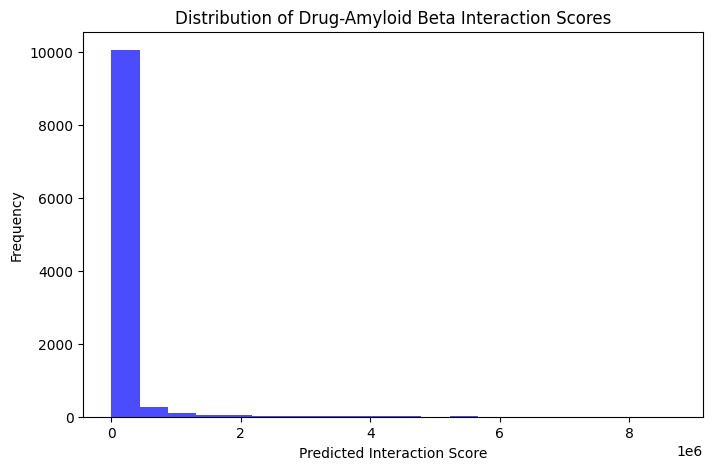

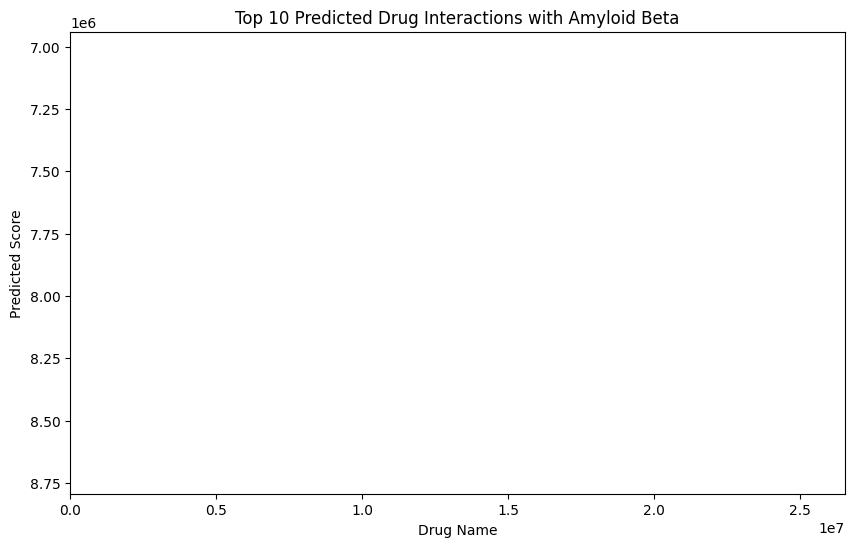

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

results_path = "/content/drug_repurposing_results.csv"
results = pd.read_csv(results_path)

plt.figure(figsize=(8,5))
plt.hist(results['Predicted_Score'], bins=20, color='blue', alpha=0.7)
plt.xlabel("Predicted Interaction Score")
plt.ylabel("Frequency")
plt.title("Distribution of Drug-Amyloid Beta Interaction Scores")
plt.show()

top_10 = results.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_10['Predicted_Score'], top_10['Drug_ID'], color='green')
plt.ylabel("Predicted Score")
plt.xlabel("Drug Name")
plt.title("Top 10 Predicted Drug Interactions with Amyloid Beta")
plt.gca().invert_yaxis()
plt.show()

# SMILES to IUPAC

In [16]:
from rdkit import Chem
import requests
import pandas as pd
import time

# Function to convert SMILES to IUPAC using PubChem API
def smiles_to_iupac(smiles):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IUPACName/TXT"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response.text.strip()
        else:
            return "Conversion Failed"
    except Exception as e:
        return str(e)

# Load the saved results file
results_path = "/content/drug_repurposing_results.csv"
results = pd.read_csv(results_path)

# Convert SMILES to IUPAC (with delay to avoid rate limiting)
results['IUPAC_Name'] = results['Drug'].apply(lambda x: smiles_to_iupac(x))

# Save the updated results file
converted_results_path = "/content/drug_repurposing_results_with_iupac.csv"
results.to_csv(converted_results_path, index=False)
print(f"Converted results saved to: {converted_results_path}")

# Display some results
display(results.head())

KeyboardInterrupt: 